## Reproduce figure 2 of Litwin-Kumar Doiran 2012

Use data from the simulated balanced network to reproduce the figure 2. 

In [1]:
import sys 
from utils import *
%matplotlib inline
import time

In [2]:
# specify data folder 
folder = '/Users/Jan/Dropbox/Master/mackelab/code/balanced_clustered_network/data/'

# give filename for uniform and clustered data 
fn_uni = '150099112552ree10_dur100_brain1.p'
fn_clus = '150091388063ree25_dur100_brain1.p'

# filename params 
time_str = time.time()
dur = '10s'

# load data 
d_uni = load_data(fn_uni, folder)
d_clus = load_data(fn_clus, folder)

In [3]:
# assume a single long trial, use only E neurons
# extract parameters 

# set time window for ff  in sec 
window_length_ff = 0.1  
# and for rho 
window_length_rho = 0.05 

# time windows for ff ocer time windows 
time_windows = np.linspace(0.025, 0.2, 8)

# get the params 
params = d_uni['params']
n_rounds = params['n_rounds']
n_trials = params['n_trials']
simulation_time = np.asarray(params['simulation_time'])  # remove unit
NE = params['NE']
NI = params['NI']
n_clusters = 50

# get the total number of neurons pairs that are in a cluster 
Nc = NE / n_clusters
n_pairs_in_cluster = n_clusters * Nc**2
n_random_pairs = int(np.sqrt(n_pairs_in_cluster))

time_offset = 1.  # in sec
delta_t = simulation_time - time_offset  # in sec
recordings_length = delta_t

In [4]:
stat_dict=dict(uniform={}, clustered={})
keys = ['uniform', 'clustered']

for idx, data in enumerate([d_uni, d_clus]): 

    spiketimedict = data['trial0']['spikes_E']

    # rates 
    spikecounts = get_spikecounts_fixed_time_window(spiketimedict, time_offset, delta_t)
    stat_dict[keys[idx]]['rates'] = spikecounts / delta_t
    
    # fano factors 
    spikecounts_over_windows_ff = get_spike_counts_over_time_windows(spiketimedict, time_offset, delta_t, 
                                                                      window_length=window_length_ff)
    stat_dict[keys[idx]]['ff'] = calculate_fano_factor(spikecounts_over_windows_ff)
  
    # rho all 
    spikecounts_over_windows_rho = get_spike_counts_over_time_windows(spiketimedict, time_offset, delta_t, 
                                                              window_length=window_length_rho)
    stat_dict[keys[idx]]['rho'] = calculate_correlation_matrix(spikecounts_over_windows_rho)
    
    # rho pairs is dependent on the clustering 
    if idx == 0: 
        shuffled_counts = spikecounts_over_windows_rho.copy()
        np.random.shuffle(shuffled_counts)
        rho_pairs = calculate_correlation_matrix(shuffled_counts[np.newaxis, :n_random_pairs, :])
    else:
        rho_pairs = calculate_clusterpair_correlations(spikecounts_over_windows_rho, n_clusters, Nc)
    stat_dict[keys[idx]]['rho_pairs'] = rho_pairs
    
    # ff over time windows 
    ff_over_windows = np.zeros_like(time_windows)
    for w_idx, time_window in enumerate(time_windows): 
        tmp_spikecounts = get_spike_counts_over_time_windows(spiketimedict, time_offset, delta_t, 
                                                                  window_length=time_window)
        ff_over_windows[w_idx] = calculate_fano_factor(tmp_spikecounts).mean()
        
    stat_dict[keys[idx]]['ff_over_windows'] = ff_over_windows

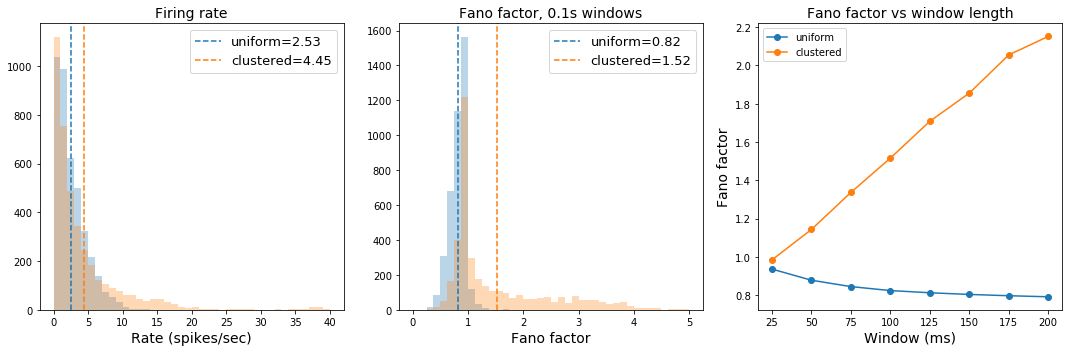

In [17]:
fontsize = 14
legend_size = 13
plt.figure(figsize=(15, 5))
colors = ['C0', 'C1']
for idx, key in enumerate(keys): 
    rates = stat_dict[key]['rates']
    ff = stat_dict[key]['ff']
    ff_over_windows = stat_dict[key]['ff_over_windows']

    # plotting 
    plt.subplot(131)
    # plot the rates 
    plt.hist(rates, bins=40, range=[0, 40], alpha=.3, lw=3.)
    plt.axvline(np.mean(rates), linestyle='--', label='{}={}'.format(key, np.round(np.mean(rates), 2)), 
                color=colors[idx])
    plt.title('Firing rate', fontsize=fontsize)
    plt.legend(prop=dict(size=legend_size))  
    plt.xlabel('Rate (spikes/sec)', fontsize=fontsize)
    
    # the ffs
    plt.subplot(132)
    plt.hist(ff, bins=40, range=[0, 5], alpha=.3, lw=3.)
    plt.title('Fano factor, {}s windows'.format(window_length_ff), fontsize=fontsize)
    plt.axvline(np.mean(ff), linestyle='--', label='{}={}'.format(key, np.round(np.mean(ff), 2)), 
                color=colors[idx])
    plt.legend(prop=dict(size=legend_size))
    plt.xlabel('Fano factor', fontsize=fontsize)
    
    # fanos over windows 
    plt.subplot(133)
    plt.title('Fano factor vs window length', fontsize=fontsize)
    plt.plot(np.round(time_windows * 1000), ff_over_windows, '-o', label='{}'.format(key))
    plt.xlabel('Window (ms)', fontsize=fontsize)
    plt.ylabel('Fano factor', fontsize=fontsize)
    plt.legend()

plt.tight_layout()
figure_filename = '{}_figure2{}_dur{}'.format(time_str, 'a', dur).replace('.', '')
save_figure(filename=figure_filename + '.pdf')

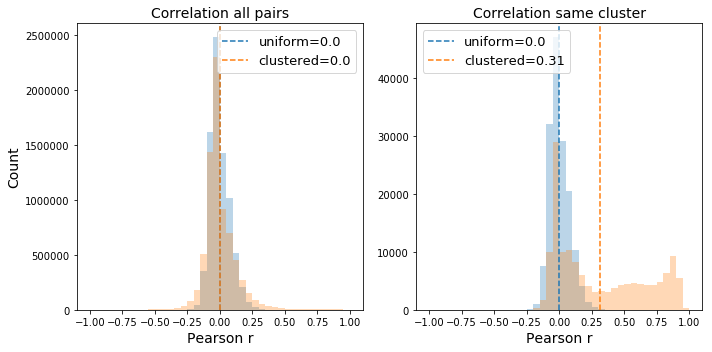

In [23]:
plt.figure(figsize=(10, 5))    
for idx, key in enumerate(keys):  
    rho = stat_dict[key]['rho']
    rho_pairs = stat_dict[key]['rho_pairs']

    # the rho
    plt.subplot(121)
    plt.hist(rho, bins=40, range=[-1, 1], alpha=.3)
    plt.title('Correlation all pairs', fontsize=fontsize)
    plt.axvline(np.mean(rho), linestyle='--', label='{}={}'.format(key, np.round(np.mean(rho), 2)), 
                color=colors[idx])
    plt.legend(prop=dict(size=legend_size))
    plt.xlabel('Pearson r', fontsize=fontsize)
    plt.ylabel('Count', fontsize=fontsize)
        
    # the rho pairs 
    plt.subplot(122)
    plt.hist(rho_pairs, bins=40, range=[-1, 1], alpha=.3)
    plt.title('Correlation same cluster', fontsize=fontsize)
    plt.axvline(np.mean(rho_pairs), linestyle='--', label='{}={}'.format(key, np.round(np.mean(rho_pairs), 2)), 
                color=colors[idx])
    plt.legend(prop=dict(size=legend_size))
    plt.xlabel('Pearson r', fontsize=fontsize)
#    plt.ylabel('Count', fontsize=fontsize)
    
plt.tight_layout()
figure_filename = '{}_figure2{}_dur{}'.format(time_str, 'b', dur).replace('.', '')
save_figure(filename=figure_filename + '.pdf')